In [1]:
import os
import zipfile
import random
import shutil
from shutil import copyfile
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import img_to_array, load_img

In [2]:
!mkdir dataset

In [3]:
import zipfile
import os

# Path to the zip file and the extraction directory
zip_path = '/content/dataset/periodontal_disease.zip'  # Path to the zip file
extract_to = '/content/dataset'  # Directory where the contents will be extracted

# Function to extract zip file
def extract_zip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"File diekstraksi ke: {extract_to}")

# Create extraction directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract the zip file
extract_zip_file(zip_path, extract_to)

# Optionally, remove the zip file after extraction
os.remove(zip_path)

File diekstraksi ke: /content/dataset


In [6]:
dataset_dir = '/content/dataset/periodontal_disease'

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

val_normal_dir = '/content/dataset/periodontal_disease/val/normal'
val_inflammation_dir = '/content/dataset/periodontal_disease/val/inflammation'

train_normal_dir = '/content/dataset/periodontal_disease/train/normal'
train_inflammation_dir = '/content/dataset/periodontal_disease/train/inflammation'


In [9]:
#Number of images for each class
print(f"There are {len(os.listdir(train_dir))} labels for training")
print(f"There are {len(os.listdir(val_dir))} labels for testing")

print(f"There are {len(os.listdir(train_normal_dir))} images of NORMAL for training")
print(f"There are {len(os.listdir(train_inflammation_dir))} images of INFLAMMATION for training")
print(f"There are {len(os.listdir(val_normal_dir))} images of NORMAL for testing")
print(f"There are {len(os.listdir(val_inflammation_dir))} images of INFLAMMATION for testing")

There are 2 labels for training
There are 2 labels for testing
There are 50 images of NORMAL for training
There are 82 images of INFLAMMATION for training
There are 16 images of NORMAL for testing
There are 28 images of INFLAMMATION for testing


Sample Normal Image:


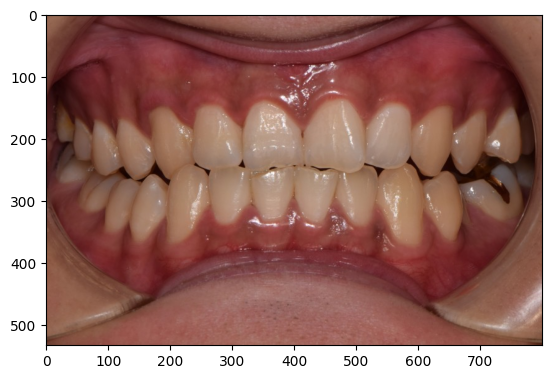


Sample Inflammation Image:


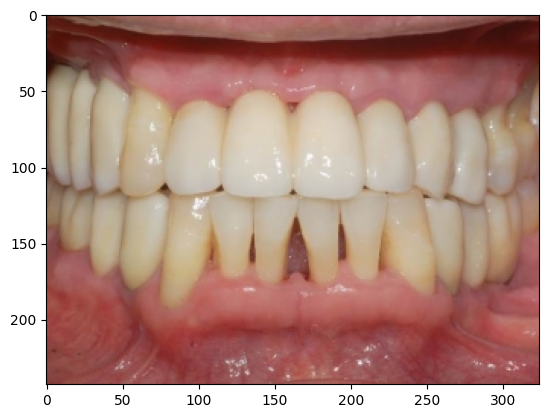

In [10]:
print("Sample Normal Image:")
plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[1])}"))
plt.show()

print("\nSample Inflammation Image:")
plt.imshow(load_img(f"{os.path.join(train_inflammation_dir, os.listdir(train_inflammation_dir)[1])}"))
plt.show()

In [11]:
normal_sample_image = load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[1])}")
normal_sample_array = img_to_array(normal_sample_image)

inflammation_sample_image = load_img(f"{os.path.join(train_inflammation_dir, os.listdir(train_inflammation_dir)[1])}")
inflammation_sample_array = img_to_array(inflammation_sample_image)

print(f"Each image has shape: {normal_sample_array.shape}")
print(f"Each image has shape: {inflammation_sample_array.shape}")

Each image has shape: (533, 800, 3)
Each image has shape: (243, 324, 3)


In [12]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest'
      )

  train_generator = train_datagen.flow_from_directory(
      directory = TRAINING_DIR,
      target_size = (200,200),
      batch_size = 64,
      class_mode = 'binary')

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow_from_directory(
      directory = VALIDATION_DIR,
      target_size = (200, 200),
      batch_size = 64,
      class_mode = 'binary')

  return train_generator, validation_generator

In [ ]:
# train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, remove_center)

In [13]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 132 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


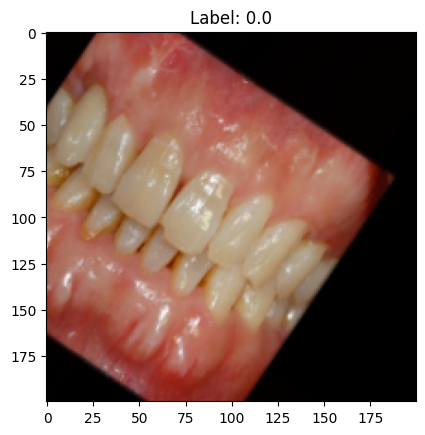

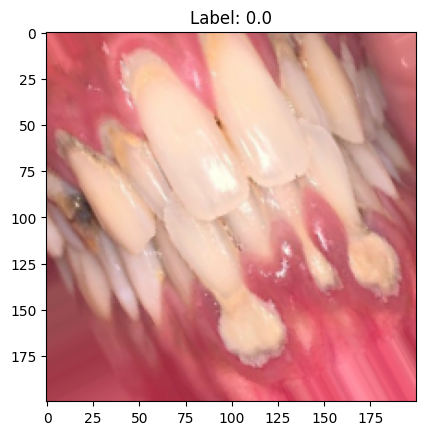

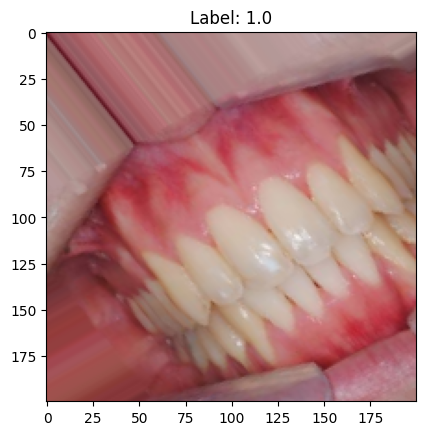

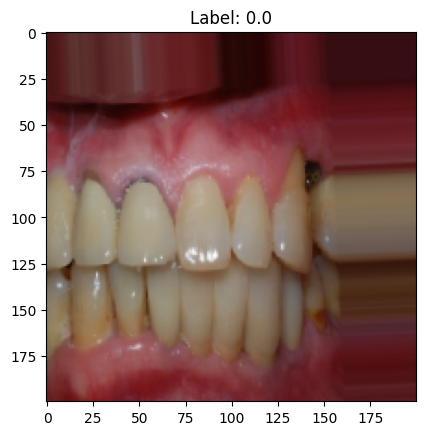

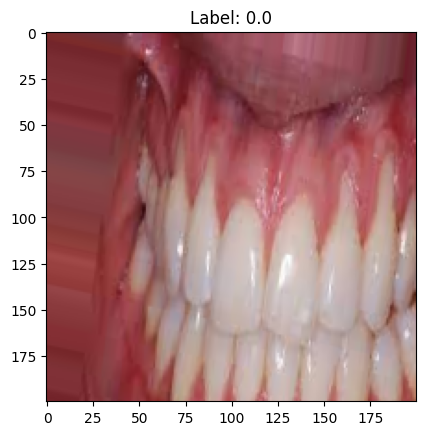

In [14]:
import matplotlib.pyplot as plt

def visualize_samples(generator, num_samples=5):
  """Visualizes a few samples from the given generator."""

  images, labels = next(generator)
  for i in range(min(num_samples, images.shape[0])):
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()

# Call the function with your train_generator
visualize_samples(train_generator)

In [15]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-07-29 07:18:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.207, 172.253.122.207, 172.253.63.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   154MB/s    in 0.5s    

2024-07-29 07:18:37 (154 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [17]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(
      input_shape = (200, 200, 3),
      include_top = False,
      weights = None)

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [18]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 99, 99, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 99, 99, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 99, 99, 32)           0         ['batch_normalizati

In [19]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check if 'val_accuracy' exists in the logs before comparing
    if logs.get('accuracy', 0) > 0.8 and logs.get('val_accuracy', 0) > 0.8:
      print("\nReached 80% accuracy so cancelling training!")
      self.model.stop_training = True

In [21]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [22]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 10, 10, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [23]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs = pre_trained_model.input, outputs = x)

  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

In [24]:
model = create_final_model(pre_trained_model, last_output)

total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 87,620,513 total parameters in this model.
There are 78,645,249 trainable parameters in this model.


In [25]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/100
3/3 - 27s - loss: 3.9532 - accuracy: 0.5227 - val_loss: 1.5144 - val_accuracy: 0.6364 - 27s/epoch - 9s/step
Epoch 2/100
3/3 - 19s - loss: 1.4253 - accuracy: 0.5985 - val_loss: 0.6506 - val_accuracy: 0.6364 - 19s/epoch - 6s/step
Epoch 3/100
3/3 - 21s - loss: 0.7491 - accuracy: 0.5455 - val_loss: 0.8552 - val_accuracy: 0.6364 - 21s/epoch - 7s/step
Epoch 4/100
3/3 - 19s - loss: 0.7070 - accuracy: 0.6364 - val_loss: 0.6685 - val_accuracy: 0.5909 - 19s/epoch - 6s/step
Epoch 5/100
3/3 - 21s - loss: 0.6583 - accuracy: 0.6212 - val_loss: 0.6847 - val_accuracy: 0.5227 - 21s/epoch - 7s/step
Epoch 6/100
3/3 - 19s - loss: 0.6362 - accuracy: 0.6515 - val_loss: 0.6498 - val_accuracy: 0.6136 - 19s/epoch - 6s/step
Epoch 7/100
3/3 - 19s - loss: 0.5842 - accuracy: 0.6970 - val_loss: 0.6464 - val_accuracy: 0.6136 - 19s/epoch - 6s/step
Epoch 8/100
3/3 - 19s - loss: 0.7479 - accuracy: 0.5682 - val_loss: 0.6907 - val_accuracy: 0.5227 - 19s/epoch - 6s/step
Epoch 9/100
3/3 - 21s - loss: 0.5240 - a

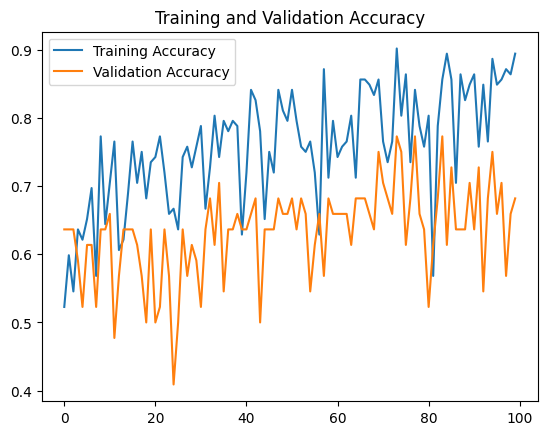

<Figure size 640x480 with 0 Axes>

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 0)
plt.figure()

plt.show()

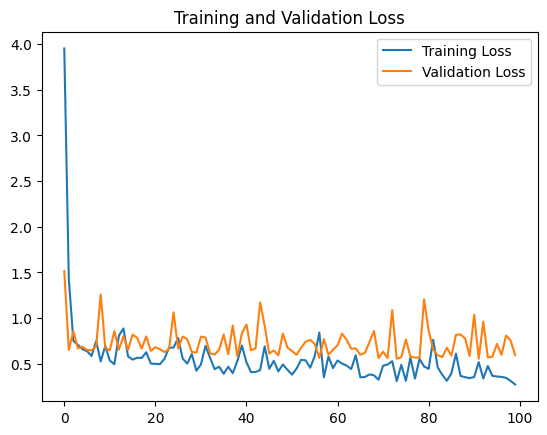

<Figure size 640x480 with 0 Axes>

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.legend(loc = 0)
plt.figure()

plt.show()

In [28]:
# 1. Memuat model yang telah dilatih
model.save('final_model.h5')
loaded_model = tf.keras.models.load_model('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
import numpy as np
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# 1. Memuat model yang sudah dilatih
loaded_model = load_model('final_model.h5')

# 2. Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(200, 200))  # Sesuaikan dengan ukuran input model (misalnya 299x299 untuk InceptionV3)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi
    return img_array

# 3. Mengunggah dan memprediksi gambar
def predict_image(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_label = class_names[predicted_class_index]
    # return class_label

    # Membuat output dalam format JSON
    result = {
        'predicted_class_index': int(predicted_class_index),
        'predicted_class_label': class_label,
        'prediction_scores': prediction.tolist()  # Mengubah array numpy ke list agar dapat diserialisasi ke JSON
    }
    return json.dumps(result, indent=4)

class_names = ['normal', 'inflammation']  # Pastikan ini sesuai dengan kelas dalam model Anda

# Path ke gambar yang akan diprediksi
image_path = '/content/dataset/periodontal_disease/test/inflammation/n00000003_000166.jpg'

# Prediksi gambar dan cetak hasilnya
predicted_class_json = predict_image(image_path, loaded_model)
print(predicted_class_json)


1/1 [==============================] - 1s 1s/step
{
    "predicted_class_index": 0,
    "predicted_class_label": "normal",
    "prediction_scores": [
        [
            0.014611461199820042
        ]
    ]
}
